# Weather Data 
From ALLL Available sources PPG, NOAA Tula, ASCC station, and my stations

Notes: 
    for now use daily values. can sub to hourly later maybe if need
    
    # Old method for ppg data based on static datasets,, us the API instead  (Eventiually) 
(note no other NOAA stations are worth their salt) 
    

In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

#%matplotlib inline
%matplotlib notebook

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import io
import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf
import re

# import function from current working directory
from getRainfallData import getRainfallData


pd.set_option('display.max_rows', 5000)    
np.set_printoptions(suppress=True)

Using TensorFlow backend.
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cshul

# Pull UH-ASPA data off of my GitHub site
note, reflects ost recent update of processed data, not raw data

In [ ]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Wx_REPO/workspace/QA_All_merged.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

#### get the data into memory

In [ ]:
rawdata = pd.read_csv(save_to ,index_col=1,parse_dates=True)   # read in data
rawdata = rawdata.drop(rawdata.columns[0], axis=1)             # get rid of pesky index column

param_list =  ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

param_dic = {}
for q in param_list: 
    r = re.compile(".*{}".format(q))  
    Col_list = list(filter(r.match, list(rawdata.columns)))
    tempframe = rawdata[Col_list]
    param_dic[q] = tempframe
    
# resample the rainfall to hourly values using a sum method
param_dic['RNF_in'] = param_dic['RNF_in'].resample('D').sum()     # subsample the 15 min data into daily values
# resample all others to hourly values using a average method
ave_param_list = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'WND_deg', 'WNS_mph'] 
for i in ave_param_list:
    param_dic[i] = param_dic[i].resample('D').mean()     # subsample the 15 min data into daily values

# Exoloratory Plot  All the datasets 
for i in param_list: 
    param_dic[i].plot(subplots=True, figsize=(12, 8))
    plt.tight_layout()
    plt.legend(loc='best')  

# Tula Data
From Tula weather station, pre-downloaded and living in a file folder, Tula site is: https://www.esrl.noaa.gov/gmd/obop/smo/

### careful, long run time

In [ ]:
# processing Tula data into a single dataframe
path_Tula_data = os.path.join("..", "Data", 'External_weather_data', 'Tula', "Met")

trash_cols = ['SITE CODE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'WND', 'WNS_mpsec', 'WND_STEADY', 'BAR_p', 'TMP_2m', 'TMP_10m', 'TMP_top', 'HMD', 'PRECIP_mm']
want_cols = ['Date', 'PRECIP_mm', 'HMD', 'TMP_2m', 'WND', 'WNS_mpsec']

files = os.listdir(path_Tula_data)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 
temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat

for i in files: 
    q = pd.read_csv(os.path.join(path_Tula_data, i), delim_whitespace=True, names=trash_cols, na_values=na_values) # open each file
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_data2 = temp_data[want_cols].set_index("Date") 

# Now resampling data into neeed formats   this is set up for daily resampling 
tula_data2['Tmp_max'] = tula_data2['TMP_2m']                   # just make the columns get ready for resampling
tula_data2['Tmp_min'] = tula_data2['TMP_2m']                  # just make the columns get ready for resampling
tula_data2 = tula_data2.rename(columns={'TMP_2m': 'TMP_ave'})  # just make the columns get ready for resampling

tula_data_rn = tula_data2['PRECIP_mm'].resample('D').sum()      # resample the rain different than the other columns
tula_data_tmax = tula_data2['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
tula_data_tmin = tula_data2['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
tula_data_others = tula_data2[['HMD', 'TMP_ave', 'WND', 'WNS_mpsec']].resample('D').mean()   
Tula_data = tula_data_others.join(tula_data_rn)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmin)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmax)                 #merge tehm back together

# unit conversions
Tula_data['RNF_in'] =  Tula_data['PRECIP_mm'].apply(lambda x: x*0.0393701)     # convert rain in mm to rain in inches
Tula_data['TMP_ave_F'] =  Tula_data['TMP_ave'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['WNS_mph'] =  Tula_data['WNS_mpsec'].apply(lambda x: x*2.23694)     # convert rain in mm to rain in inches
del Tula_data['WNS_mpsec']; del Tula_data['TMP_ave']; del Tula_data['PRECIP_mm']; 

# this block is to deal with the separate solar radiation (SLR )files
Path_go_SLR = os.path.join("..", "Data", 'External_weather_data', 'Tula', 'Slr') 

trash_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'DIRECT', 'DIFFUSE2', 'D_GLOBAL', 'D_IR', 'Zenith']
want_cols = ["Date", "DIRECT"]

SLR_files = os.listdir(Path_go_SLR)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 

temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat
for i in SLR_files: 
    q = pd.read_csv(os.path.join(Path_go_SLR, i), delim_whitespace=True, skiprows= range(0,4), names=trash_cols,  na_values=na_values) # open each file     
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_SLR2 = temp_data[want_cols].set_index("Date") 
tula_data_SLR = tula_SLR2['DIRECT'].resample('D').mean()      # resample the rain different than the other columns

Tula_data = Tula_data.join(tula_data_SLR)        
Tula_data = Tula_data.rename(columns={'DIRECT': 'SLR_wpm2'})

#Tula_data = Tula_data.loc["2015-01-01 01:00:00":"2019-10-01 01:00:00"]

In [ ]:
Tula_data.plot(alpha=.5, figsize = (12,3))
Tula_data

# Processing historical ASCC data obtained from Mark

In [ ]:
path_ASCC_data_old =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'GroWeatherData 2004-2014.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_old), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 8, 12, 14, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
numcols = ['Air Temp', 'Solar Rad', 'Wind Speed', 'Rain', 'Hum']
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 
ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling

ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together


# remove trash
ASCC_All_daily[ASCC_All_daily < 0] = np.nan
ASCC_All_daily = ASCC_All_daily.loc[:"2013-12-31"]     # remove trashy data at the end of the stations life

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_old = ASCC_All_daily


############  New station   ##################
# read in data from the new weather station.
path_ASCC_data_new =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'ASCCWeatherData_2015-2018_direct.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_new), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 5, 7, 8, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
ASCC_All = ASCC_All.rename(columns={'OutTemp':'Air Temp', 'HumOut':'Hum', 'SpeedWind':'Wind Speed', 'Rad.Solar':'Solar Rad'})
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 

ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling


ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_new = ASCC_All_daily

# merge old and new
ASCC_All_combined = pd.concat([ASCC_All_daily_old, ASCC_All_daily_new])

In [ ]:
#fig, ax, = plt.subplots()
ASCC_All_combined.plot(figsize =(12,3))
ASCC_All_combined

# PPG Airport Data
 from http://scacis.rcc-acis.org/ for daily data  and also from: https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:61705/detail for hourly data


In [2]:
# Old method based on static datasets,, us the API instead  (Eventiually) 


path_PPG_data = os.path.join("..", "Data", 'External_weather_data', 'PPG', "daily")                # open dataset
PPG = pd.read_csv(os.path.join(path_PPG_data, 'PPG-2000-oct2-19-daily.csv'), usecols = [2, 5, 13, 18, 19]) #  ,21])  will give wind directions
PPG['DATE'] = pd.to_datetime(PPG['DATE'], errors='coerce')
PPG = PPG.set_index('DATE')

# Now Hourly Airport Data  (junkshow) for needed only for RH data, not in the daily file for some reason, 
path_PPG_data_RH = os.path.join("..", "Data", 'External_weather_data', 'PPG', "hourly")                # open dataset

a = pd.read_csv(os.path.join(path_PPG_data_RH, 'PPG_2010-2019(oct)-hourly.csv'), usecols = [1,2,3, 48])  # cut out rando columns
b = pd.read_csv(os.path.join(path_PPG_data_RH, 'PPG-2000-2009-hourly.csv'), usecols = [1,2,3, 48])       # cut out rando columns
c = pd.concat([b, a])                                                                                    # merge em together

c = c[c['REPORT_TYPE'] == 'FM-15']                                       # apparently the hourly data we want is codes as FM-15 Data
c['DATE'] = pd.to_datetime(c['DATE'], errors='coerce')                   # string date to real date
c['DATE'] = c['DATE'].dt.round('H')                                      # timestamps are in rando near hour times, round to the hour
c = c.set_index('DATE')
del c['REPORT_TYPE']
del c['SOURCE']
c = c.apply(pd.to_numeric, errors='coerce')                       # convert all columns of DataFrame to floats, turns any non-numerics to nan

#  resample to daily values 
PPG_RH_dat = c.resample('D').mean()      # resample the rain different than the other columns
PPG_RH_dat.rename(columns={'HourlyRelativeHumidity': 'RH_pct'}, inplace=True)      # rename column


PPG = PPG.join(PPG_RH_dat)                 #merge the datasets together


#PPG = PPG.loc["2015-01-01 01:00:00":"2019-09-01 01:00:00"]


C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>


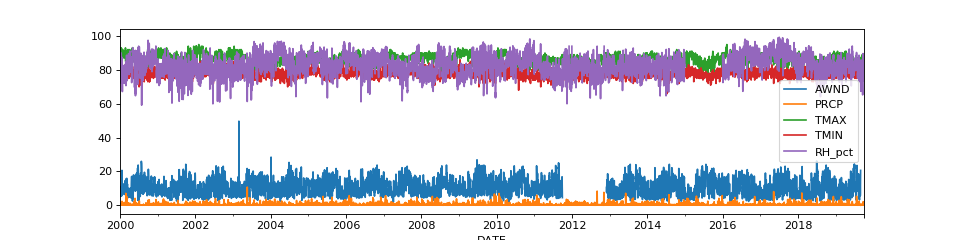

In [3]:
PPG.plot(figsize =(12,3))
#PPG

In [118]:
 # First: all of this is to go through each dataset and identify the start and the end of each gap. Also fill in single day gaps with adjacient day data
dataset_raw = PPG.copy()
Colinterest = 'RH_pct'

gapstarts_Dates, gapends_Dates =  find_date_gaps(dataset_raw, Colinterest)
    
###### Now just fill gaps of one day by using average of yesterday's and tomorrow's values
for idx, val in enumerate(gapstarts_Dates):
    strt = gapstarts_Dates[idx]
    ends = gapends_Dates[idx] 
    
    if ends - strt == pd.Timedelta('1 day'):
        beforepoint = dataset_raw[Colinterest].loc[strt-pd.Timedelta('1 day')]
        afterpoint = dataset_raw[Colinterest].loc[ends]
        avepoint = np.mean((beforepoint,afterpoint))
        
        dataset_raw[Colinterest].loc[strt] = avepoint
        
PPG_data_smallfilled = dataset_raw.copy()

In [119]:
#### From  TS prediction tutrial 

In [120]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)

In [172]:
gapstarts_Dates, gapends_Dates =  find_date_gaps(PPG_data_smallfilled, Colinterest)    # ID the gaps after filling the single day ones

gooddataend = gapstarts_Dates[0]-pd.Timedelta('1 day')                                # this is where the good data ends

# Create the dataset to train on
dataset = PPG_data_smallfilled['RH_pct'].loc[:gooddataend]
dataset = dataset.to_frame()
#dataset = np.asarray(dataset, 'float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


3147 1551


In [173]:
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 4s - loss: 0.0320
Epoch 2/10
 - 4s - loss: 0.0126
Epoch 3/10
 - 4s - loss: 0.0119
Epoch 4/10
 - 4s - loss: 0.0118
Epoch 5/10
 - 4s - loss: 0.0119
Epoch 6/10
 - 4s - loss: 0.0119
Epoch 7/10
 - 4s - loss: 0.0119
Epoch 8/10
 - 4s - loss: 0.0119
Epoch 9/10
 - 4s - loss: 0.0119
Epoch 10/10
 - 4s - loss: 0.0119


In [175]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.25 RMSE
Test Score: 4.29 RMSE


<IPython.core.display.Javascript object>


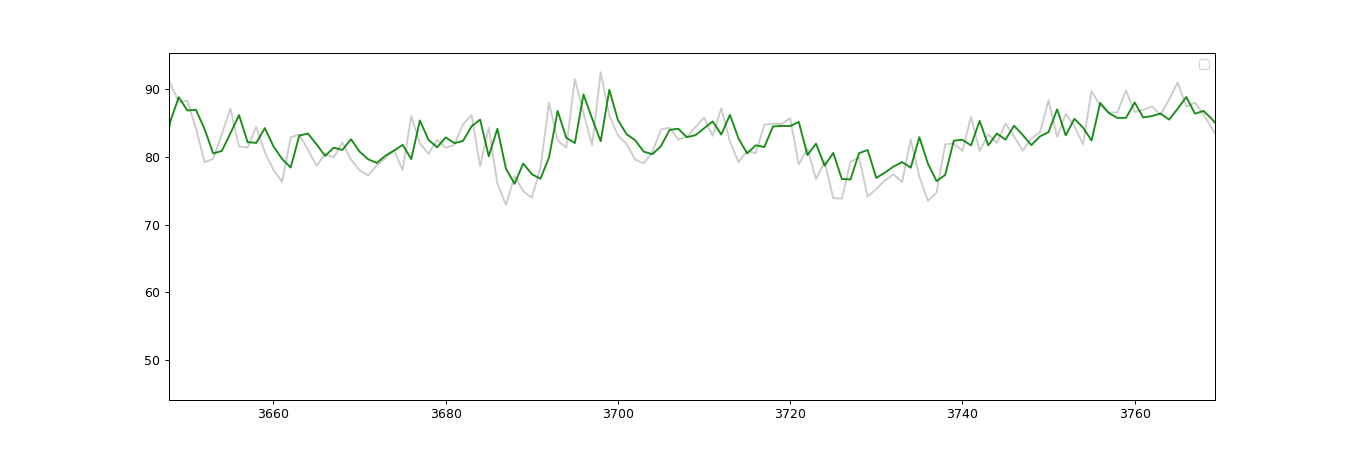

No handles with labels found to put in legend.


In [176]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# plot baseline and predictions
fig, ax = plt.subplots(figsize =(15,5))
plt.plot(scaler.inverse_transform(dataset), color = 'grey', alpha = .4)
plt.plot(trainPredictPlot, color ='b', alpha = .9)
plt.plot(testPredictPlot, color ='g', alpha = .9)
plt.legend()
plt.show()

In [144]:
# test with the mastery tutorual 

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

dataset  = pd.read_csv(save_to ,usecols=[1], engine='python')   # read in data


# Explorations into grabbing data from API's 

# Unused for now

# Pull Data from our ASCC station off weather underground 
Using this https://www.shanelynn.ie/analysis-of-weather-data-using-pandas-python-and-seaborn/


In [ ]:


def getRainfallData(station, day, month, year):
    """
    Function to return a data frame of minute-level weather data for a single Wunderground PWS station.
    
    Args:
        station (string): Station code from the Wunderground website
        day (int): Day of month for which data is requested
        month (int): Month for which data is requested
        year (int): Year for which data is requested
    
    Returns:
        Pandas Dataframe with weather data for specified station and date.
    """
    url = "http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={station}&day={day}&month={month}&year={year}&graphspan=day&format=1"
    full_url = url.format(station=station, day=day, month=month, year=year)
    # Request data from wunderground data
    response = requests.get(full_url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
    data = response.text
    # remove the excess <br> from the text data
    data = data.replace('<br>', '')
    # Convert to pandas dataframe (fails if issues with weather station)
    try:
        dataframe = pd.read_csv(io.StringIO(data), index_col=False)
        dataframe['station'] = station
    except Exception as e:
        print("Issue with date: {}-{}-{} for station {}".format(day,month,year, station))
        return None
    return dataframe    

In [ ]:
# Generate a list of all of the dates we want data for
start_date = "2015-08-01"
end_date = "2018-08-01"
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))

# Create a list of stations here to download data for
stations = ["IWESTERN499"]
# Set a backoff time in seconds if a request fails
backoff_time = 10
data = {}

# Gather data for each station in turn and save to CSV.
for station in stations:
    print("Working on {}".format(station))
    data[station] = []
    for date in dates:
        # Print period status update messages
        if date.day % 10 == 0:
            print("Working on date: {} for station {}".format(date, station))
        done = False
        while done == False:
            try:
                weather_data = getRainfallData(station, date.day, date.month, date.year)
                done = True
            except ConnectionError as e:
                # May get rate limited by Wunderground.com, backoff if so.
                print("Got connection error on {}".format(date))
                print("Will retry in {} seconds".format(backoff_time))
                time.sleep(10)
        # Add each processed date to the overall data
        data[station].append(weather_data)
    Big_dataframe = pd.concat(data[station])  # .to_csv("data/{}_weather.csv".format(station))


# Downloading Noaa data direct from API (does not give hourly data or RH!)
from https://gettecr.github.io/noaa-api.html#.XaZ9gkZKhaQ

When want to do things better, more like this;;;

https://www.ncdc.noaa.gov/cdo-web/token

Email:	1553charnelton@gmail.com
Token:	uYChiVPXWdiFdZbgaCbTGBNtghxqGiJy
    

In [ ]:
# gibberish code
    
    
    
from key import APIkey

import requests
import datetime
import numpy as np
import pandas as pd
import os
import sys
    
base_url_catergories = "https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets"
token = {'token': mytoken}

#Location key for the region you are interested in (can be found on NOAA or requested as a different API as well)
locationid = 'FIPS:60' #location id for North Dakota
datasetid = 'CLI' #datset id for "Daily Summaries"


params = 'datasetid='+str(datasetid)+'&'+'locationid='+str(locationid)+'&'+'startdate='+str(begin_date)+'&'+'enddate='+str(end_date)+'&'+'limit=25'+'&'+'units=standard'

r = requests.get(base_url_catergories, headers = token)
#df = pd.DataFrame.from_dict(r.json()['results'])
#df

#plist = ["PRCP", "TMAX", "TMIN", "AWND"

r.json()


params = 'datasetid='+str(datasetid)+'&'+'locationid='+str(locationid)+'&'+'startdate='+str(begin_date)+'&'+'enddate='+str(end_date)+'&'+'limit=25'+'&'+'units=standard'
base_url_data = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'

r = requests.get(base_url_data, params = params, headers=token)
df = pd.DataFrame.from_dict(r.json()['results'] )
df


r.json()['results']



mytoken = APIkey

#Use the datetime package to get a year ago today
lastyear = datetime.datetime.now()-datetime.timedelta(days=365)

#Use the same begin and end date for just one day's data. Format for the API request
begin_date = "2001-01-01"
end_date = "2001-01-09"

#Location key for the region you are interested in (can be found on NOAA or requested as a different API as well)
locationid = 'FIPS:60' #location id for North Dakota
datasetid = 'GHCND' #datset id for "Daily Summaries"

base_url_data = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
base_url_stations = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations'

def get_weather(locationid, datasetid, begin_date, end_date, mytoken, base_url):
    token = {'token': mytoken}

    #passing as string instead of dict because NOAA API does not like percent encoding
    params = 'datasetid='+str(datasetid)+'&'+'locationid='+str(locationid)+'&'+'startdate='+str(begin_date)+'&'+'enddate='+str(end_date)+'&'+'limit=25'+'&'+'units=standard'
    print(params)
    
    r = requests.get(base_url, params = params, headers=token)
    print("Request status code: "+str(r.status_code))

    try:
        #results comes in json form. Convert to dataframe
        df = pd.DataFrame.from_dict(r.json()['results'])
        print("Successfully retrieved "+str(len(df['station'].unique()))+" stations")
        dates = pd.to_datetime(df['date'])
        print("Last date retrieved: "+str(dates.iloc[-1]))

        return df

    #Catch all exceptions for a bad request or missing data
    except:
        print("Error converting weather data to dataframe. Missing data?")
        
    
        
df_weather = get_weather(locationid, datasetid, begin_date, end_date, mytoken, base_url_data)

df_weather



def get_station_info(locationid, datasetid, mytoken, base_url):
    token = {'token': mytoken}

    #passing as string instead of dict because NOAA API does not like percent encoding
    
    stations = 'locationid='+str(locationid)+'&'+'datasetid='+str(datasetid)+'&'+'units=standard'+'&'+'limit=1000'
    r = requests.get(base_url, headers = token, params=stations)
    print("Request status code: "+str(r.status_code))

    try:
        #results comes in json form. Convert to dataframe
        df = pd.DataFrame.from_dict(r.json()['results'])
        print("Successfully retrieved "+str(len(df['id'].unique()))+" stations")
        
        if df.count().max() >= 1000:
            print('WARNING: Maximum data limit was reached (limit = 1000)')
            print('Consider breaking your request into smaller pieces')
 
        return df
    #Catch all exceptions for a bad request or missing data
    except:
        print("Error converting station data to dataframe. Missing data?")
        
df_stations = get_station_info(locationid, datasetid, mytoken, base_url_stations)


df = df_weather.merge(df_stations, left_on = 'station', right_on = 'id', how='inner')

#Check for missing overlap between station weather info and location info
    
location_ismissing = df_weather[~df_weather['station'].isin(df_stations['id'])]
loc_miss_count = len(location_ismissing['station'].unique())
if loc_miss_count != 0:
    print("Missing location data for "+str(loc_miss_count)+" stations")
else:
    print("Successfully retrieved and combined location data")



![image.png](attachment:image.png)




![image.png](attachment:image.png)
dancehall queen

In [67]:

def find_date_gaps(dataset_raw, Colinterest):

    a = dataset_raw[Colinterest].values  # Extract out relevant column from dataframe as array
    ## Now gap filling time: 
    # First: all of this is to go through each dataset and identify the start and the end of each gap. 

    m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

    gapstarts_L = []; gapends_L = []
    # this is if the series started late, i.e. the first gap is at the beginning
    if ss[0][0] != 0:     
        gapstart = 0
        gapstarts_L.append(gapstart)
        for m in ss:
            gapstart2 = m[1]
            gapstarts_L.append(gapstart2)
            gapends_L.append(m[0])
        del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

    # this is if the series starst at the beginning of the data period, first gap is in the middle 
    for m in ss:
        gapstarts_L.append(m[1])
        gapends_L.append(m[0])
    del gapstarts_L[-1]
    del gapends_L[0]

    gapstarts_Dates = []; gapends_Dates = []
    for h in gapstarts_L:
        date5 = dataset_raw.index[h]
        gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
    for h in gapends_L:
        date5 = dataset_raw.index[h]
        gapends_Dates.append(date5)     # this is a list of all the ending dates of the gaps
        
    return gapstarts_Dates, gapends_Dates

In [ ]:
# old code for backup 

 # First: all of this is to go through each dataset and identify the start and the end of each gap. 
dataset_raw = PPG.copy()
Colinterest = 'RH_pct'



a = dataset_raw[Colinterest].values  # Extract out relevant column from dataframe as array
## Now gap filling time: 
# First: all of this is to go through each dataset and identify the start and the end of each gap. 

m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

gapstarts_L = []; gapends_L = []
# this is if the series started late, i.e. the first gap is at the beginning
if ss[0][0] != 0:     
    gapstart = 0
    gapstarts_L.append(gapstart)
    for m in ss:
        gapstart2 = m[1]
        gapstarts_L.append(gapstart2)
        gapends_L.append(m[0])
    del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

# this is if the series starst at the beginning of the data period, first gap is in the middle 
for m in ss:
    gapstarts_L.append(m[1])
    gapends_L.append(m[0])
del gapstarts_L[-1]
del gapends_L[0]

gapstarts_Dates = []; gapends_Dates = []
for h in gapstarts_L:
    date5 = dataset_raw.index[h]
    gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
for h in gapends_L:
    date5 = dataset_raw.index[h]
    gapends_Dates.append(date5)     # this is a list of all the ending dates of the gap 

    
###### Now just fill gaps of one day by using average of yesterday's and tomorrow's values
for idx, val in enumerate(gapstarts_Dates):
    strt = gapstarts_Dates[idx]
    ends = gapends_Dates[idx] 
    
    if ends - strt == pd.Timedelta('1 day'):
        beforepoint = dataset_raw[Colinterest].loc[strt-pd.Timedelta('1 day')]
        afterpoint = dataset_raw[Colinterest].loc[ends]
        avepoint = np.mean((beforepoint,afterpoint))
        
        dataset_raw[Colinterest].loc[strt] = avepoint
        
dataset = dataset_raw.copy()
